In [2]:
import rasterio
import numpy as np
import pandas as pd
import geopandas as gpd
import os

from pathlib import Path
from typing import List, Tuple, Optional, Union
from rasterio.enums import MergeAlg
from rasterio import features

import sys
if sys.version_info < (3, 9):
    from importlib_resources import files
else:
    from importlib.resources import files

from beak.utilities.conversions import create_geodataframe_from_points, create_geodataframe_from_polygons, _rasterize_vector_process
from beak.utilities.io import save_raster, check_path, load_raster, load_dataset


# Load data

**User definitions**

In [43]:
BASE_PATH = files("beak.data")
PATH_LABELS = BASE_PATH / "CRITICAL_MINERALS" / "hypersite_nickel_us_data.csv"
PATH_BASE_RASTER = BASE_PATH / "BASE_RASTERS" / "EPSG_4326_RES_0_025_CLIPPED_USC.tif"


In [44]:
mineral_sites = load_dataset(PATH_LABELS)

Histogram mineral sites complete data set

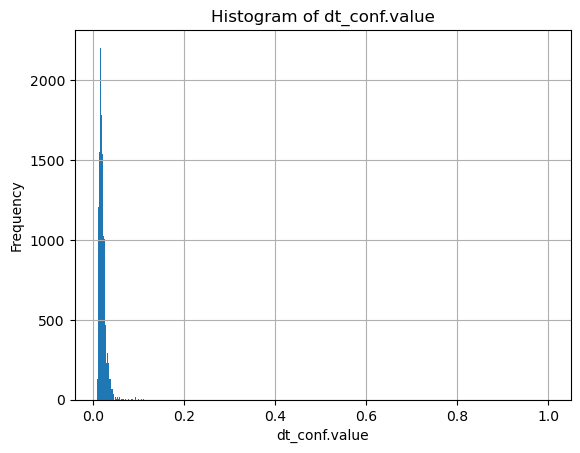

In [16]:
import matplotlib.pyplot as plt

mineral_sites['dt_conf.value'].hist(bins=1000)
plt.xlabel('dt_conf.value')
plt.ylabel('Frequency')
plt.title('Histogram of dt_conf.value')
plt.show()


Histogram mineral sites unique locations with maximum confidence

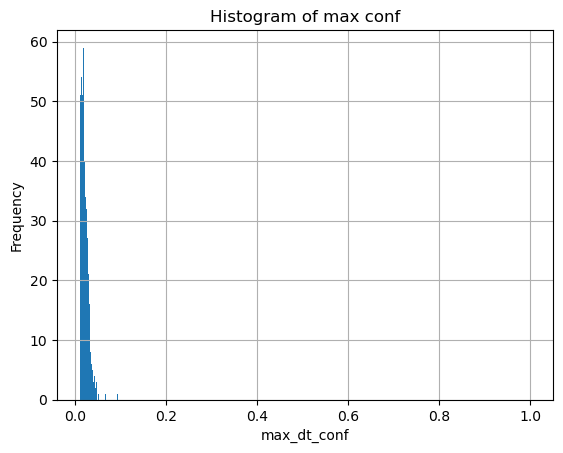

In [38]:
mineral_sites['max_dt_conf'] = mineral_sites.groupby('loc_wkt.value')['dt_conf.value'].transform('max')

# Unique Locations
mineral_sites_filtered = mineral_sites.drop_duplicates(subset='loc_wkt.value')
len(mineral_sites_filtered)

import matplotlib.pyplot as plt

mineral_sites_filtered['max_dt_conf'].hist(bins=1000)
plt.xlabel('max_dt_conf')
plt.ylabel('Frequency')
plt.title('Histogram of max conf')
plt.show()

Filtering

In [45]:
# Filter ophiolites
filtered_mineral_sites_oph = mineral_sites[mineral_sites['dtnorm_label.value'] != 'Ophiolite nickel-copper-PGE']
len(filtered_mineral_sites_oph)


22224

In [46]:
# Filter confidence
filtered_mineral_sites_oph_conf = filtered_mineral_sites_oph[filtered_mineral_sites_oph['dt_conf.value'] >= 0.025]
len(filtered_mineral_sites_oph_conf)


3585

In [47]:
# Get unique locations
mineral_sites_filtered_final = filtered_mineral_sites_oph_conf.drop_duplicates(subset='loc_wkt.value')
len(mineral_sites_filtered_final)

172

In [48]:
mineral_sites_filtered_final.to_csv('mineral_sites_filtered_final.csv', index=False)


In [42]:
mineral_sites_filtered_final

,Unnamed: 0.1,ms.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,loc_wkt.value,oms.value,Unnamed: 0,source,source_id,prediction,ms_record_id.value,ms_source_id.value,site_hyper_id,max_dt_conf
0,0,https://minmod.isi.edu/resource/mrds10056259,0.032008,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-109.79635 45.35242),https://minmod.isi.edu/resource/mrds10048508,770.0,MRDS,10056259,1442.0,10056259,MRDS,https://minmod.isi.edu/resource/1442,0.032008
20,20,https://minmod.isi.edu/resource/mrds10197903,0.028549,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-114.14251 36.62439),NaN,1946.0,MRDS,10197903,311.0,10197903,MRDS,https://minmod.isi.edu/resource/311,0.035864
116,116,https://minmod.isi.edu/resource/mrds10136902,0.030263,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,POINT (-135.0381 57.79693),NaN,1619.0,MRDS,10136902,1414.0,10136902,MRDS,https://minmod.isi.edu/resource/1414,0.030263
437,437,https://minmod.isi.edu/resource/mrds10056251,0.035008,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-110.16941 45.47103),https://minmod.isi.edu/resource/mrds10042345,763.0,MRDS,10056251,819.0,10056251,MRDS,https://minmod.isi.edu/resource/819,0.035008
472,472,https://minmod.isi.edu/resource/mrds10282983,0.036132,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q476,Komatiite nickel-copper-PGE,United States,POINT (-136.47095 57.88301),NaN,2503.0,MRDS,10282983,732.0,10282983,MRDS,https://minmod.isi.edu/resource/732,0.036132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26743,26743,https://minmod.isi.edu/resource/mrds10002386,0.029162,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,POINT (-135.19196 57.04193),NaN,61.0,MRDS,10002386,338.0,10002386,MRDS,https://minmod.isi.edu/resource/338,0.029162
26855,26855,https://minmod.isi.edu/resource/site__birch-la...,1.000000,expert,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,USA,POINT (-91.8 47.75),NaN,NaN,NaN,NaN,-1.0,NaN,NaN,https://minmod.isi.edu/resource/-1,1.000000
27000,27000,https://minmod.isi.edu/resource/mrds10117276,0.027758,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,United States,POINT (-105.27198 40.08029),https://minmod.isi.edu/resource/mrds10108244,1485.0,MRDS,10117276,188.0,10117276,MRDS,https://minmod.isi.edu/resource/188,0.029030
27184,27184,https://minmod.isi.edu/resource/site__spruce-r...,1.000000,expert,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,USA,POINT (-91.7 47.83),NaN,NaN,NaN,NaN,-1.0,NaN,NaN,https://minmod.isi.edu/resource/-1,1.000000


# Create Labels

## From shapefile

In [62]:
import geopandas as gpd
from rasterio.crs import CRS
from beak.utilities.conversions import create_binary_raster
from beak.utilities.conversions import create_geodataframe_from_polygons
from shapely.wkt import loads
from shapely.geometry import Point

#gdf = create_geodataframe_from_polygons(mineral_sites_filtered_final, polygon_col='loc_wkt.value', epsg_code=4326)

crs = CRS.from_epsg(4326)
data = mineral_sites_filtered_final.copy()
gdf = gpd.GeoDataFrame(data, geometry="loc_wkt.value", crs=crs)
gdf["geometry"] = gdf.geometry

base_raster = load_raster(PATH_BASE_RASTER)
out_path = BASE_PATH / "TRAINING_LABELS" / "MAGMATIC_NICKEL_TA2_EPSG_4326_RES_0_025_CLIPPED_USC.tif"


In [ ]:
labels_array = create_binary_raster(gdf, base_raster, all_touched=False, same_shape=True, fill_negatives=True, out_file=out_path)